In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
import pandas as pd
from pandas import Series, DataFrame
from pandas import concat
pd.set_option('display.max_columns', None)
#显示所有行
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, GRU
from math import sqrt
import keras.optimizers
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor
 #fix random seed for reproducibility
from matplotlib import pyplot
import graphviz

np.random.seed(2019)


# 定义一个可以将序列数据转化成监督学习所需数据的函数
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

C:\Users\xuxiaoqing\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def find_max(data,span=1):
    data_len = data.shape[0]
    span_len = data_len//span
    span_max_all = []
    for i in range(span_len):
        span_max = np.max(data[i*span:(i+1)*span])
        span_max_all.append(span_max)
    span_max_all = np.array(span_max_all)
    return span_max_all.reshape(-1,1)

In [3]:
def outlier_process(data,thre=3):
    data_output= data.copy()
    [r, l] = data.shape
    for i in range(r):
        for j in range(l):
           
            if i == 0:
                if (data[i,j]>thre*data[i+1,j] and data[i,j]>thre*data[i+2,j]) or (data[i,j]<data[i+1,j]/thre and data[i,j]<data[i+2,j]/thre):
                    data_output[i,j] = (data[i+1,j]+data[i+2,j])/2
            elif i>0 and i<r-1:
                
                if (data[i,j]>thre*data[i-1,j] and data[i,j]>thre*data[i+1,j]) or (data[i,j]<data[i-1,j]/thre and data[i,j]<data[i+1,j]/thre):
                    data_output[i,j] = (data[i-1,j]+data[i+1,j])/2
            else:
                if (data[i,j]>thre*data[i-1,j] and data[i,j]>thre*data[i-2,j]) or (data[i,j]<data[i-1,j]/thre and data[i,j]<data[i-2,j]/thre):
                    data_output[i,j] = (data[i-1,j]+data[i-2,j])/2
    return data_output 

In [4]:
def persistence(last_ob, n_predict):
    return [last_ob for i in range(n_predict)]

In [5]:
def mape_error(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100

In [6]:
def mae_error(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true))

In [7]:
def corr_find(data1,data2):
    cor = stats.pearsonr(data1, data2)
    return cor[0]

In [8]:
def data_sum(data):
    return data.sum(axis=1)

In [9]:
citys = ['12','13','19','23','8','18','4','1','5','3','10',
         '22','7','2','6','16','14','20','11','9','17','21','15']

In [10]:
# 选择某个终点城市
# traffic = np.load('t_sum_GEANT.npy')
start_city = '16'
start_city_num = citys.index(start_city)
# raw_data = traffic[start_city_num, :, :].transpose()
#sum_city = np.zeros(raw_data[:,1].shape)
# %matplotlib auto
end_city = '5'
end_city_num = citys.index(end_city)
raw_data_uni = raw_data[:,end_city_num]

In [11]:
raw_data_uni[raw_data_uni >500000]=0

C:\Users\xuxiaoqing\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


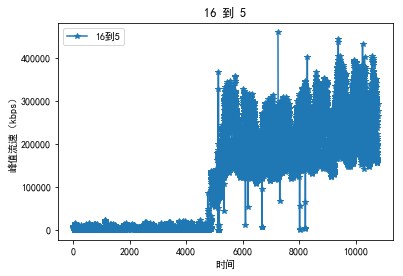

In [12]:
plt.figure()
plt.plot(range(1,len(raw_data_uni)+1), raw_data_uni, '-*',label= start_city+'到'+end_city)
plt.legend()
plt.xlabel('时间')
plt.ylabel('峰值流速（kbps）')
plt.title('%s 到 %s'%(start_city,end_city))
plt.show()

In [13]:
raw_data_uni_partial = raw_data_uni[-24*4*7*2-24*4*7:]

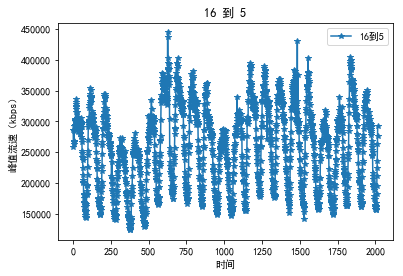

In [14]:
plt.figure()
plt.plot(range(1,len(raw_data_uni_partial)+1), raw_data_uni_partial, '-*',label= start_city+'到'+end_city)
plt.legend()
plt.xlabel('时间')
plt.ylabel('峰值流速（kbps）')
plt.title('%s 到 %s'%(start_city,end_city))
plt.show()

In [15]:
raw_data_uni_partial = raw_data_uni_partial.reshape(-1,1)
raw_data_uni_partial.shape

(2016, 1)

In [16]:
train_size = 24*4*7*2

validation_size = 0
test_size = 24*4*7

look_back = 24*4*1
n_predict = 24*4*2

In [17]:
train_size

1344

In [18]:
test_size

672

In [19]:
def create_dataset(dataset, look_back=7, n_predict=3):   
    X, Y = [], []
    for i in range(len(dataset)-look_back-n_predict+1): 
        obs = dataset[i:(i+look_back), 0]
# Sequence of 7 stock prices as features forming an observation
# Append sequence
        X.append(obs)
       # Append stock price value occurring 4 time-steps into future
        Y.append(dataset[i+look_back:i + (look_back+n_predict), 0]) 
    return np.array(X), np.array(Y)

In [20]:
train_data = create_dataset(raw_data_uni_partial[:train_size], look_back=look_back, n_predict=n_predict)
# validation_data = create_dataset(raw_data_uni_partial[train_size:train_size+validation_size], look_back=look_back, n_predict=n_predict)
test_data = create_dataset(raw_data_uni_partial[train_size+validation_size:train_size+validation_size+test_size], look_back=look_back, n_predict=n_predict)

In [21]:
train_x = train_data[0]
train_y = train_data[1]
# validation_x = validation_data[0]
# validation_y = validation_data[1]
test_x = test_data[0]
test_y = test_data[1]

In [22]:
n_feature = 1
n_delay = look_back
n_obs = n_delay * n_feature  # 一个样本中的所有输入特征


print(train_x.shape, train_y.shape,test_x.shape,test_y.shape)

(1057, 96) (1057, 192) (385, 96) (385, 192)


In [23]:
#随机森林
method = '随机森林'
model = RandomForestRegressor(n_estimators=10,verbose=1)
model.fit(train_x, train_y)
yhat = model.predict(test_x)


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.7s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


In [24]:
# multioutputregressor = MultiOutputRegressor(xgb.XGBRegressor(n_estimators=1000)).fit(train_x, train_y)
# method = 'Xgboost'
# #对测试集进行预测
# yhat = multioutputregressor.predict(test_x)

In [25]:
# multioutputregressor = MultiOutputRegressor(GradientBoostingRegressor(n_estimators=100)).fit(train_x, train_y)
# yhat = multioutputregressor.predict(test_x)
# method = 'GBDT'

In [26]:
yhat.shape

(385, 192)

In [27]:
# make a persistence forecast
def persistence(last_ob, n_predict):
    return [last_ob for i in range(n_predict)]

compare_base = raw_data_uni_partial[:, 0]
compare_base_total = []
for i in range(yhat.shape[0]):
    compare_base1 = compare_base[-yhat.shape[0]+i-1]
    compare_base2 = persistence(compare_base1, n_predict)
    compare_base_total.append(compare_base2)
compare_base_total = np.array(compare_base_total)
# print(compare_base_total)

In [28]:
# print(yhat)
print(yhat[0])
print(yhat.shape)
print(test_y.shape)

[281978.60623 295753.19112 295593.09778 303691.37335 318470.44267
 324278.74579 324178.28445 329605.69957 331926.79821 335152.68445
 341380.83467 342304.62045 346487.50488 348176.57868 345375.79465
 346068.84798 347712.75288 346101.61956 344495.81244 344550.99556
 353933.96712 350569.69512 345114.13957 335844.97866 333832.65068
 325501.1298  327214.82579 317220.104   314873.70224 311027.46579
 317720.92801 316085.34401 316235.47466 312644.82044 312463.312
 310841.62933 313946.70577 317368.8098  313122.05867 306659.10844
 301769.9191  296499.58311 298031.21244 301959.07733 299374.83822
 296710.25334 296089.784   300136.99733 300504.63023 298660.00536
 297787.97421 293257.70933 286941.74846 283945.36979 281303.88444
 274710.17513 272869.85689 260792.11912 252698.73512 245382.69068
 241398.71466 232739.45511 229091.82489 222314.76178 218535.51288
 212045.57956 206055.12975 202154.904   201908.61778 194597.35112
 189736.18221 187688.01421 184891.19644 179583.19644 178889.9911
 175732.39376

In [29]:
rmse = sqrt(mean_squared_error(test_y, yhat))
print(method+'预测的RMSE: %.3f' % rmse)

随机森林预测的RMSE: 27689.558


In [30]:
rmse1 = sqrt(mean_squared_error(test_y, compare_base_total))
print('简单预测的RMSE: %.3f'% rmse1)

简单预测的RMSE: 92012.702


In [31]:
%matplotlib auto

Using matplotlib backend: Qt5Agg


In [32]:
predict_data = raw_data_uni_partial[:, 0].copy()
predict_data[-n_predict:] = yhat[-1]
compare_data = raw_data_uni_partial[:, 0].copy()
compare_data[-n_predict:] = compare_base_total[-n_predict]

actual_data = raw_data_uni_partial[:, 0].copy()
actual_data[-n_predict::] = test_y[-1]

rmse = sqrt(mean_squared_error(test_y, yhat))
rmse1 = sqrt(mean_squared_error(test_y, compare_base_total))

mae = mae_error(test_y, yhat)
mae1 = mae_error(test_y, compare_base_total)
mape = mape_error(test_y, yhat)
mape1 = mape_error(test_y, compare_base_total)


plt.figure()
plt.plot(range(1,len(yhat[-1])+1),yhat[-1], '-*', label=method+'预测数据')
plt.plot(range(1, len(test_y[-1])+1),compare_base_total[-n_predict], '-^',label= '简单预测数据')
plt.plot(range(1,len(test_y[-1])+1), test_y[-1], '-o',label= '实际数据')
plt.legend()
plt.xlabel('时间')
plt.ylabel('峰值流速（kbps）')
plt.title('%s 到 %s'%(start_city+'节点',end_city+'节点'))
# plt.text(0, 400000, method+'预测的RMSE: %.3f'% rmse) 
# plt.text(0, 410000, '简单预测的RMSE: %.3f'% rmse1) 


plt.text(0, 400000, method+'预测的MAE: %.3f'% mae) 
plt.text(0, 410000, '简单预测的MAE: %.3f'% mae1)
plt.show()

plt.figure()
plt.plot(range(1,len(predict_data)+1),predict_data, '-*', label=method+'预测数据')
plt.plot(range(1, len(predict_data)+1),compare_data, '-^',label= '简单预测数据')
plt.plot(range(1,len(predict_data)+1), raw_data_uni_partial[:, 0], '-o',label= '实际数据')
plt.legend()
plt.xlabel('时间')
plt.ylabel('峰值流速（kbps）')
plt.title('%s 到 %s'%(start_city+'节点',end_city+'节点'))
plt.text(0, 430000, method+'预测的MAE: %.3f'% mae) 
plt.text(0, 420000, '简单预测的MAE: %.3f'% mae1)
plt.text(0, 410000, method+'预测的MAPE: %.3f'% mape+'%') 
plt.text(0, 400000, '简单预测的MAPE: %.3f'% mape1+'%')
plt.show()

# plt.figure()
# plt.plot(range(1,len(predict_data)+1), raw_data_uni_partial[:, 0], '-o',label= '实际数据')
# plt.plot(range(1,len(predict_data)+1), actual_data, '-*',label= '实际数据2')
# plt.legend()
# plt.xlabel('时间')
# plt.ylabel('峰值流速（kbps）')
# plt.title('%s 到 %s'%(start_city+'节点',end_city+'节点'))
# plt.show()
# rmse = sqrt(mean_squared_error(test_y, yhat))
# print(method+'预测的RMSE: %.3f' % rmse)
# rmse1 = sqrt(mean_squared_error(test_y, compare_base_total))
# print('简单预测的RMSE: %.3f'% rmse1)



rmse = sqrt(mean_squared_error(test_y[-1], yhat[-1]))
print(method+'预测的RMSE: %.3f' % rmse)
rmse1 = sqrt(mean_squared_error(test_y[-1], compare_base_total[-n_predict]))
print('简单预测的RMSE: %.3f'% rmse1)

随机森林预测的RMSE: 36737.036
简单预测的RMSE: 70593.769
